# Support Vector Machine (SVM)
In this assignment, you will classify tweets using the SVM algorithm to predict their sentiment.

*Please* fill in your details below to help us keep track of your submission.

Student Name: `Fatemeh Hamdi`

Student ID: `401105848`

In [250]:
import nltk
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer

### Load the database and show data.

In [251]:
import pandas as pd

path = 'sentiment.csv'

data = pd.read_csv(path, encoding = "ISO-8859-1")

data = data[:20000]

In [252]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Step 1: Data Exploration
Note that in the cells where you need to display a chart, it is not necessary to follow the exact style of the chart.

### Plot the labels with their corresponding numbers.

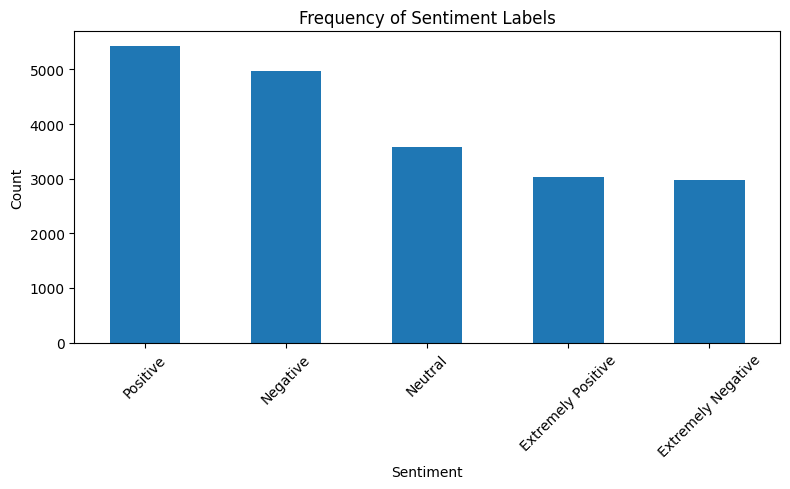

In [253]:
sentiment_counts = data['Sentiment'].value_counts()

plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar')
plt.title('Frequency of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Plot the distribution of tweets according to their lengths.

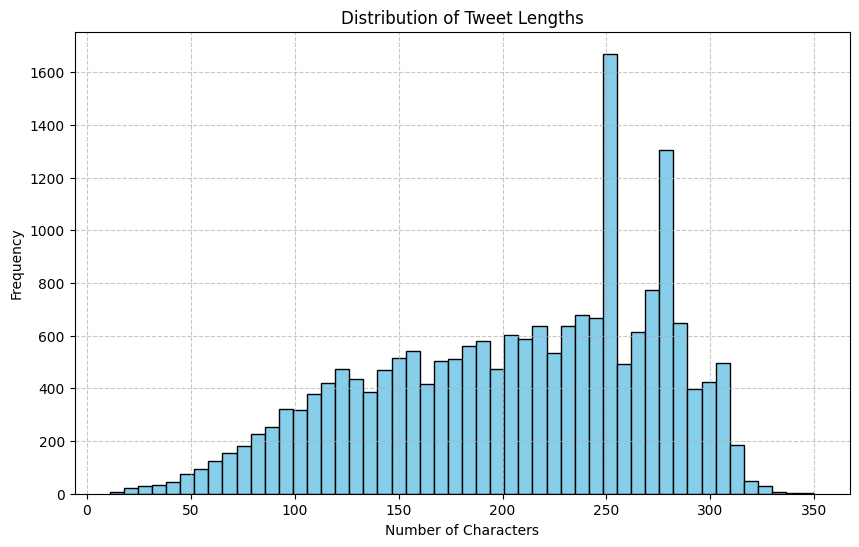

In [255]:
# Calculate tweet lengths
sentiment_counts = data['OriginalTweet'].apply(len)

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(sentiment_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Drop the rows with missing values.

In [225]:
# Drop rows with any missing values
data = data.dropna()

### Plot the frequency of 30 most top frequent words in `Negative`, `Neutral`, and `Positive` classes individually.

In [257]:
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [258]:
def process_tweets(tweets):
    words = []
    for tweet in tweets:
        # Tokenize each tweet
        tokens = word_tokenize(str(tweet).lower())
        # Remove stop words and keep only alphabetic words with length > 1
        clean_words = [word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 1]
        words.extend(clean_words)
    return words

def frequency_plot(words, title):
    labels = [word[0] for word in words]
    counts = [word[1] for word in words]

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 30 Words - {title}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

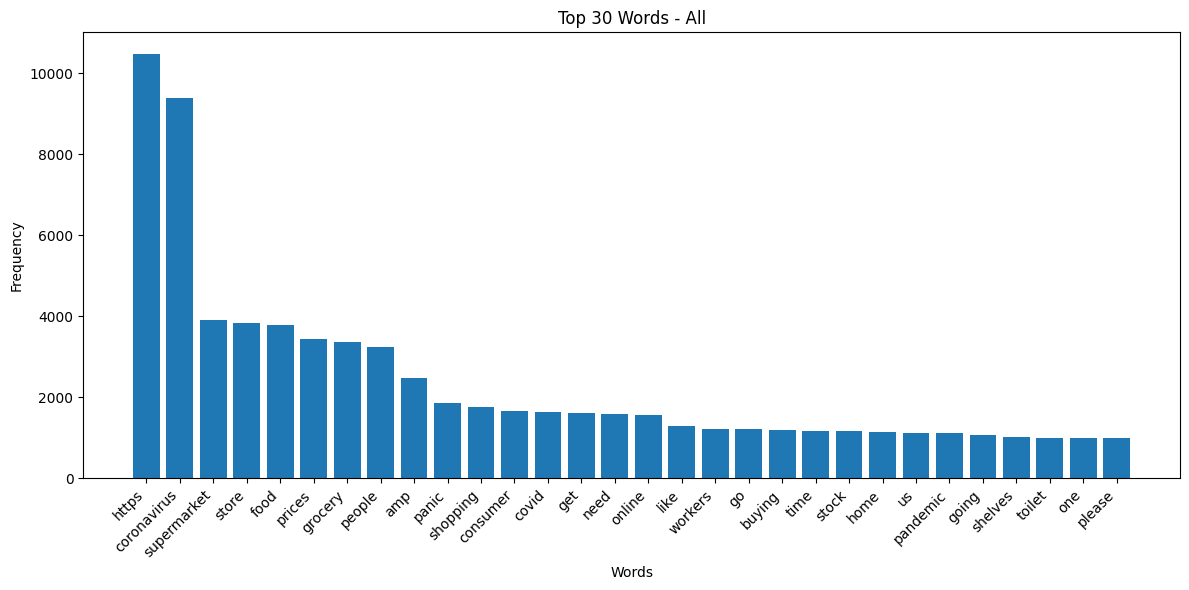

In [259]:
all_tweet_words = process_tweets(data['OriginalTweet'])
top = Counter(all_tweet_words).most_common(30)
frequency_plot(top, 'All')

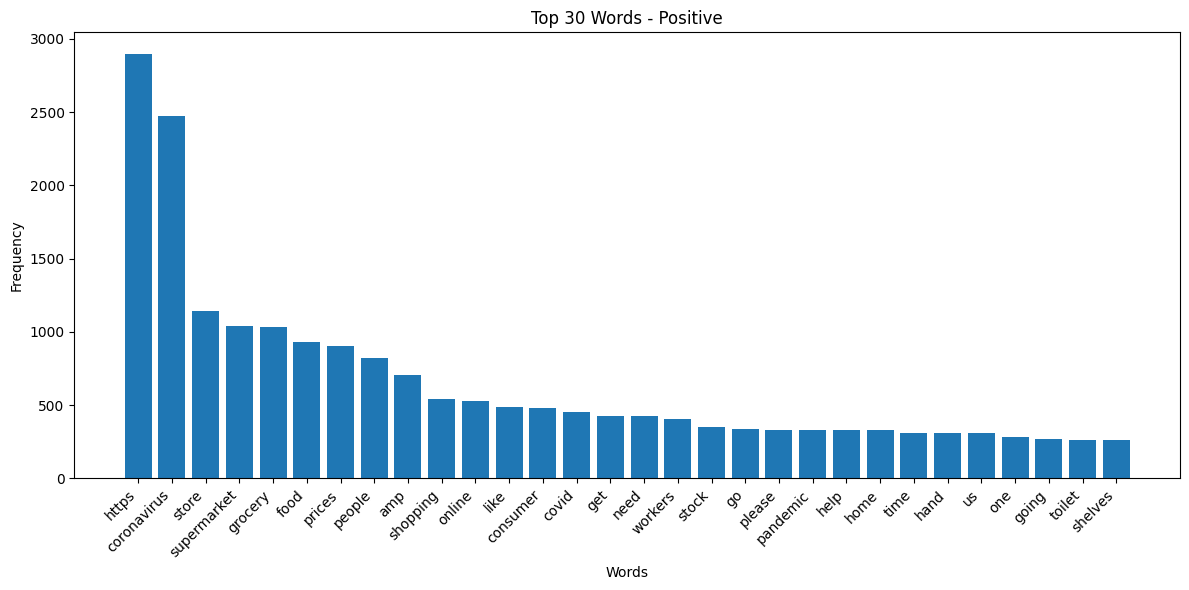

In [260]:
positive = data[data['Sentiment'] == 'Positive']['OriginalTweet']
positive_words = process_tweets(positive)
top_positive = Counter(positive_words).most_common(30)
frequency_plot(top_positive, 'Positive')

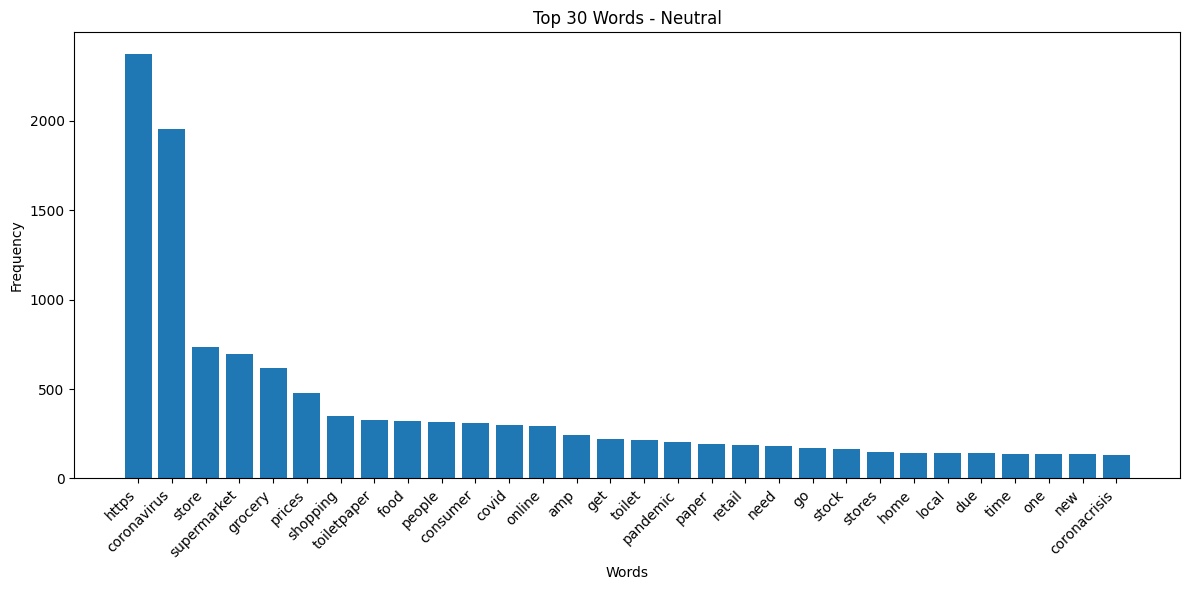

In [261]:
neutral = data[data['Sentiment'] == 'Neutral']['OriginalTweet']
neutral_words = process_tweets(neutral)
top_neutral = Counter(neutral_words).most_common(30)
frequency_plot(top_neutral, 'Neutral')

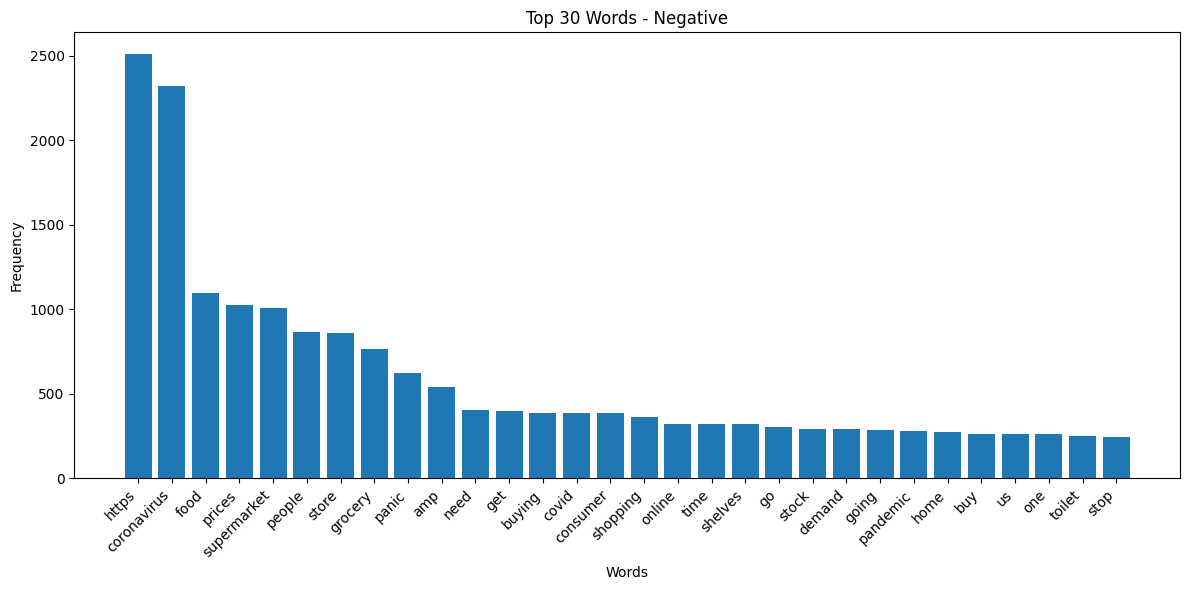

In [262]:
negative = data[data['Sentiment'] == 'Negative']['OriginalTweet']
negative_words = process_tweets(negative)
top_negative = Counter(negative_words).most_common(30)
frequency_plot(top_negative, 'Negative')

Consider `Extremely Positive` as `Positive` and `Extremely Negative` as `Negative`. Print number of data in each class.

In [263]:
# Combine extreme sentiments with their base categories
data['Sentiment'] = data['Sentiment'].replace({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
})

# Count number of data points in each class
sentiment_counts = data['Sentiment'].value_counts()

# Print the counts
print("Number of data points in each class:")
print(sentiment_counts)

Number of data points in each class:
Sentiment
Positive    8463
Negative    7961
Neutral     3576
Name: count, dtype: int64


## Step 2: Data Preprocessing

In this part, clean the dataset using the follwoing class.

In [264]:
stop_words = set(stopwords.words('english'))
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()

In [265]:
class Preprocess:
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        # initialize NLP tools
        self._tokenizer = word_tokenize
        self._stemmer = PorterStemmer()
        self._lemmatizer = WordNetLemmatizer()
        try:
            self._stop_words = set(stopwords.words('english'))
        except LookupError:
            self._stop_words = set()
        self.preprocess()

    def preprocess(self):
        self.rm_irrelevant_columns()
        self.drop_duplicate()
        self.rm_links_and_tags()
        self.clean_text()
        self.replace_root()

    def rm_irrelevant_columns(self):
        cols_to_keep = ['OriginalTweet', 'Sentiment']
        existing = [c for c in cols_to_keep if c in self.data.columns]
        self.data = self.data[existing]

    def drop_duplicate(self):
        self.data = self.data.drop_duplicates().reset_index(drop=True) # 📣

    def _rm_links_and_tags(self, text: str) -> str:
        text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
        text = re.sub(r'@\w+', ' ', text)
        return text

    def rm_links_and_tags(self):
        self.data['OriginalTweet'] = (
            self.data['OriginalTweet']
                .astype(str)
                .apply(self._rm_links_and_tags)
        )

    def _clean_text(self, text: str) -> str:
        return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    def clean_text(self):
        self.data['OriginalTweet'] = (
            self.data['OriginalTweet']
                .apply(self._clean_text)
                .str.lower()
        )

    def _replace_root(self, text: str) -> str:
        tokens = self._tokenizer(text)
        processed = []
        for tok in tokens:
            if tok.isalpha() and tok not in self._stop_words:
                stemmed = self._stemmer.stem(tok)
                lemma   = self._lemmatizer.lemmatize(stemmed)
                processed.append(lemma)
        return ' '.join(processed)

    def replace_root(self):
        self.data['ProcessedTweet'] = (
            self.data['OriginalTweet']
                .astype(str)
                .apply(self._replace_root)
        )

In [266]:
import re

nltk.download('wordnet')

preprocess = Preprocess(data)
data = preprocess.data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [267]:
data.head(10)

,OriginalTweet,Sentiment,ProcessedTweet
0,and and,Neutral,
1,advice talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,coronavirus australia woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,my food stock is not the only one which is emp...,Positive,food stock one empti plea panic enough food ev...
4,me ready to go at supermarket during the cov...,Negative,readi go supermarket outbreak paranoid food st...
5,as news of the region s first confirmed covid...,Positive,news region first confirm covid case came sull...
6,cashier at grocery store was sharing his insig...,Positive,cashier groceri store share insight covid prov...
7,was at the supermarket today didn t buy toile...,Neutral,supermarket today buy toilet paper rebel toile...
8,due to covid 19 our retail store and classroom...,Positive,due covid retail store classroom atlanta open ...
9,for corona prevention we should stop to buy th...,Negative,corona prevent stop buy thing cash use onlin p...


### Frequency Plot

### How does preprocessing affect the data?

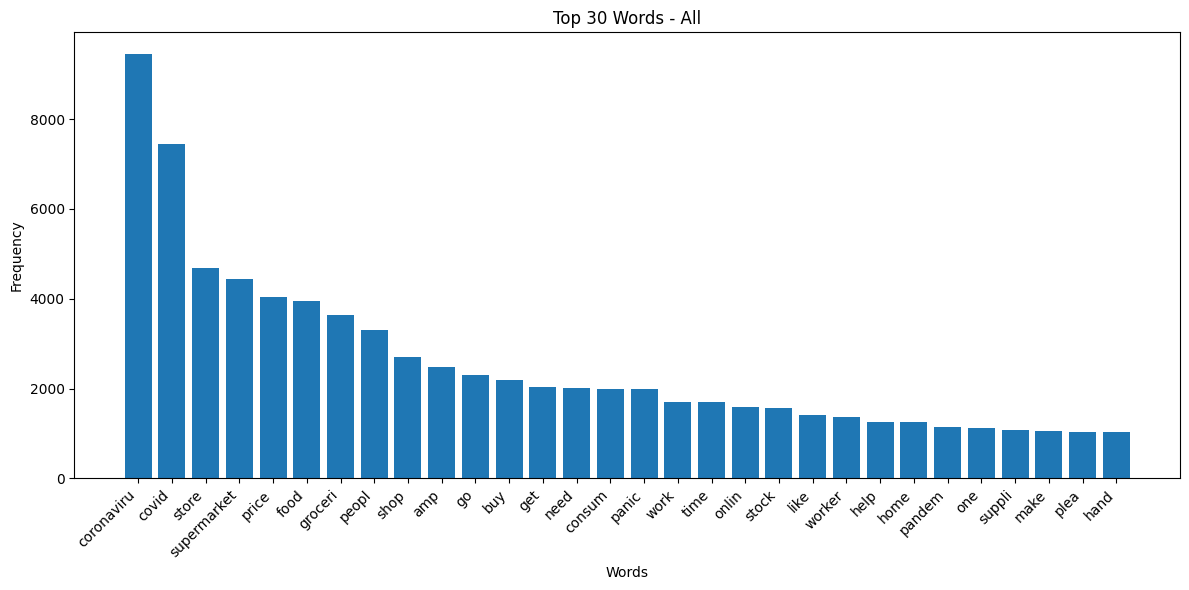

In [268]:
all_tweet_words = process_tweets(data['ProcessedTweet'])
top = Counter(all_tweet_words).most_common(30)
frequency_plot(top, 'All')

## WordCloud
Generate word cloud for `preprocessedTweet` column.

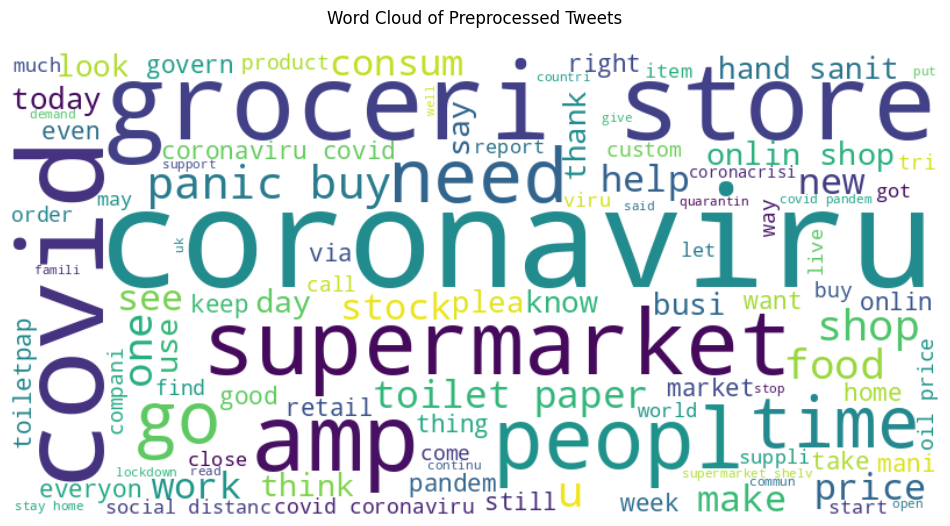

In [269]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
all_text = ' '.join(data['ProcessedTweet'])
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      max_words=100,
                      colormap='viridis').generate(all_text)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Tweets', pad=20)
plt.show()

# Step 3: Modeling
## Feature generation
Construct feature vector for each tweet using `CountVectorizer`.

In [275]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with max_features=50 to limit vocabulary size
vectorizer = CountVectorizer(max_features=50)  # Creates 50-dimensional vectors

# Create feature vectors
feature_vectors = vectorizer.fit_transform(data['ProcessedTweet'])

# Print the shape and sample of the feature matrix
print(f"Shape of feature matrix: {feature_vectors.shape}")
print(feature_vectors.toarray()[:5])  # Show first 5 tweets as examples

# Print first 20 feature names
print("\nFirst 20 feature names:")
print(vectorizer.get_feature_names_out()[:20])

Shape of feature matrix: (20000, 50)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0
  2 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
  0 1 0 0 1 0 0 0 0 0 0 0 0 0]]

First 20 feature names:
['amp' 'busi' 'buy' 'close' 'consum' 'coronaviru' 'covid' 'day' 'demand'
 'due' 'food' 'get' 'go' 'groceri' 'hand' 'help' 'home' 'keep' 'like'
 'local']


## Split data to train and test sets.

In [241]:
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test by default)
X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors,          # Your feature matrix
    data['Sentiment'],        # Corresponding labels
    test_size=0.2,            # 20% for testing
    random_state=42,          # For reproducibility
    stratify=data['Sentiment'] # Preserve class distribution
)

# Print the shapes to verify
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (12549, 50)
Test set shape: (3138, 50)

Class distribution in training set:
Sentiment
Positive    0.426488
Negative    0.392462
Neutral     0.181050
Name: proportion, dtype: float64

Class distribution in test set:
Sentiment
Positive    0.426705
Negative    0.392288
Neutral     0.181007
Name: proportion, dtype: float64


# SVM

### Use SVC class of `sklearn` with linear kernel.

In [242]:
from sklearn.svm import SVC
SVC_sklearn = SVC(kernel = 'linear')

SVC_sklearn.fit(X_train, y_train)

SVC(kernel='linear')

## SVM from scratch
Using the following class, implement a SVM classifier for `Positive` and `Negative` classes.

In [243]:
!pip install cvxopt

In [276]:
import numpy as np
import itertools
from cvxopt import matrix, solvers

class SVM:
    def __init__(self, C=1.0, tol=1e-5):
        self.C = C
        self.w = None
        self.bias = None
        self.tol = tol

    def fit(self, X, y):
        if hasattr(X, "toarray"):
            X = X.toarray()

        # TODO: Filter only 'Positive' and 'Negative' classes
        mask = np.isin(y, ['Positive', 'Negative'])
        X = X[mask]
        y = y[mask]

        unique, counts = np.unique(y, return_counts=True)

        # TODO: Convert class labels to +1 and -1
        y = np.where(y == 'Positive', 1.0, -1.0)

        n_samples, n_features = X.shape


        # TODO: Compute the kernel matrix (linear kernel)
        K = X @ X.T
        K = K.toarray() if hasattr(K, "toarray") else np.array(K)



        # TODO: Set up the QP parameters for cvxopt
        P = matrix(np.outer(y, y) * K)

        epsilon = 1e-8
        P_np = np.outer(y, y) * (K + epsilon * np.eye(len(y)))
        # — B) eigenvalue check
        eigvals = np.linalg.eigvalsh(P_np)   # full spectrum



        # compute a few eigenvalues
        eigvals = np.linalg.eigvalsh(P_np[:50, :50])   # cheaper: first 50×50 block

        q = matrix(-np.ones(n_samples))
        G_std = np.diag(-np.ones(n_samples))
        G_slack = np.diag(np.ones(n_samples))
        G = matrix(np.vstack((G_std, G_slack)))
        h_std = np.zeros(n_samples)
        h_slack = np.ones(n_samples) * self.C
        h = matrix(np.hstack((h_std, h_slack)))

        # Convert small slice to numpy to inspect
        G_np = np.vstack((G_std, G_slack))


        # Build the stacked matrix for rank check
        M = np.vstack([
            P_np,
            y.reshape(1, -1),             # A
            G_np                         # G
        ])



        A = matrix(y.reshape(1, -1))
        rank_A = np.linalg.matrix_rank(np.array(A))

        b = matrix(np.zeros(1))
        # TODO: Solve the QP problem to find lagrange multipliers
        solvers.options['show_progress'] = False # 📣
        solution = solvers.qp(P, q, G, h, A, b)
        lambdas = np.ravel(solution['x'])

        # TODO: Extract support vectors
        sv_mask = lambdas > self.tol
        self.lambdas_ = lambdas[sv_mask]
        self.support_vectors_ = X[sv_mask]
        self.support_labels_  = y[sv_mask]

        # TODO: Compute weight vector for linear SVM
        self.w = np.sum(
            self.lambdas_[:, None] * self.support_labels_[:, None] * self.support_vectors_,
            axis=0
        )

        # TODO: Compute bias
        biases = self.support_labels_ - self.support_vectors_ @ self.w
        self.bias = np.mean(biases)

    def transform(self, X):
        # TODO: Compute the decision function and assign labels # 📣
        decision = X @ self.w + self.bias
        return np.where(decision >= 0, 'Positive', 'Negative')

### Trian the SVM class with data.

In [277]:
svm = SVM()
X_small = X_train[:1000]
y_small = y_train[:1000]
svm.fit(X_small, y_small)

# Step 4: Evaluation

Apply each model on test set.

In [278]:
mask = np.isin(y_test, ['Positive', 'Negative'])
X_test = X_test[mask]
y_test = y_test[mask]
y_pred_custom = svm.transform(X_test)
y_pred_sklearn = SVC_sklearn.predict(X_test)

Print accuracy score of each model on test set.

In [279]:
from sklearn.metrics import accuracy_score

# Scikit-learn SVM accuracy (all three classes)
sklearn_accuracy = accuracy_score(y_test, SVC_sklearn.predict(X_test))
print(f"Scikit-learn SVM Accuracy: {sklearn_accuracy:.4f}")

# Custom SVM accuracy (only Positive/Negative classes)
test_mask = np.isin(y_test, ['Positive', 'Negative'])
custom_accuracy = accuracy_score(
    y_test[test_mask],
    svm.transform(X_test[test_mask].toarray())
)
print(f"Custom SVM Accuracy (Positive/Negative only): {custom_accuracy:.4f}")

Scikit-learn SVM Accuracy: 0.6350
Custom SVM Accuracy (Positive/Negative only): 0.6331


Print normalized confusion matrix of each model pridctions.

In [280]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Function to plot normalized confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Normalized Confusion Matrix\n{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()





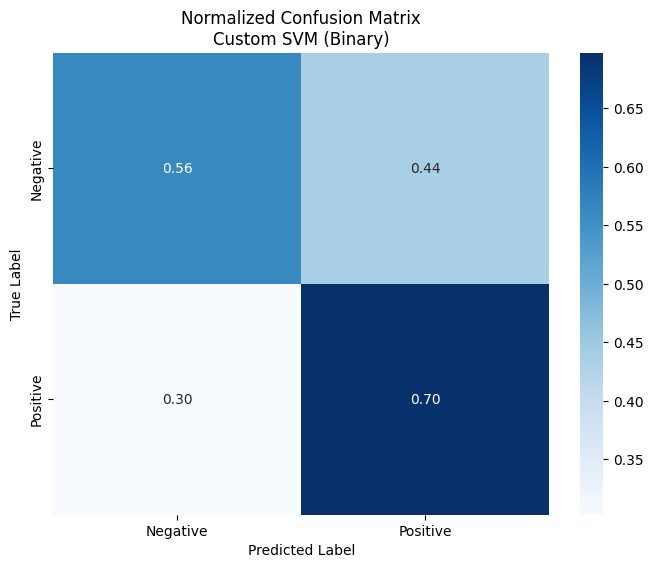

In [281]:
# Custom SVM (Positive/Negative only)
test_mask = np.isin(y_test, ['Positive', 'Negative'])
custom_pred = svm.transform(X_test[test_mask].toarray())
plot_confusion_matrix(y_test[test_mask], custom_pred,
                     classes=['Negative', 'Positive'],
                     title='Custom SVM (Binary)')

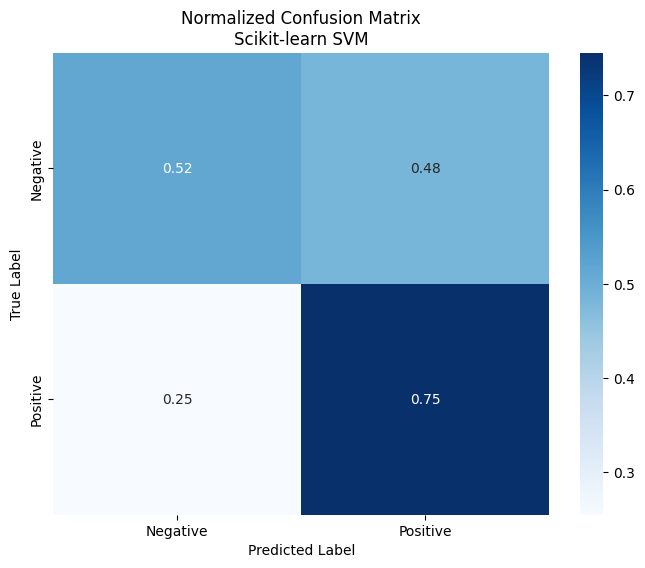

In [283]:
# Scikit-learn SVM (all three classes)
sklearn_pred = SVC_sklearn.predict(X_test)
plot_confusion_matrix(y_test, sklearn_pred,
                     classes=['Negative', 'Positive'],
                     title='Scikit-learn SVM')

## Non-linear Classification with Kernels in SVM

Until now, we've used **linear SVMs**, which try to find a linear decision boundary (a hyperplane) between classes. But what if the data is not linearly separable?

That's where **kernel functions** come in! Kernels allow SVMs to create non-linear decision boundaries by implicitly mapping the data to a higher-dimensional space without explicitly computing that mapping.

Common kernel functions:
- **Linear**: `K(x, y) = x ⋅ y`
- **Polynomial**: `K(x, y) = (x ⋅ y + c)^d`
- **RBF (Gaussian)**: `K(x, y) = exp(-γ ||x − y||²)`

Let's try them out!


## Import and Dataset Setup

In [284]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Create a dataset that's not linearly separable
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7
)

## Train SVM with Different Kernels

In [285]:
# Train SVMs with different kernels
kernels = ['linear', 'poly', 'rbf']   # 📣
models = {}

# TODO: Loop through the kernels and train an SVM for each
for kernel in kernels:
    if kernel == 'poly':
        svc = SVC(kernel=kernel, degree=3, gamma='scale')
    else:
        svc = SVC(kernel=kernel, gamma='scale')

    svc.fit(X_train, y_train)
    models[kernel] = svc

## Plot Decision Boundaries

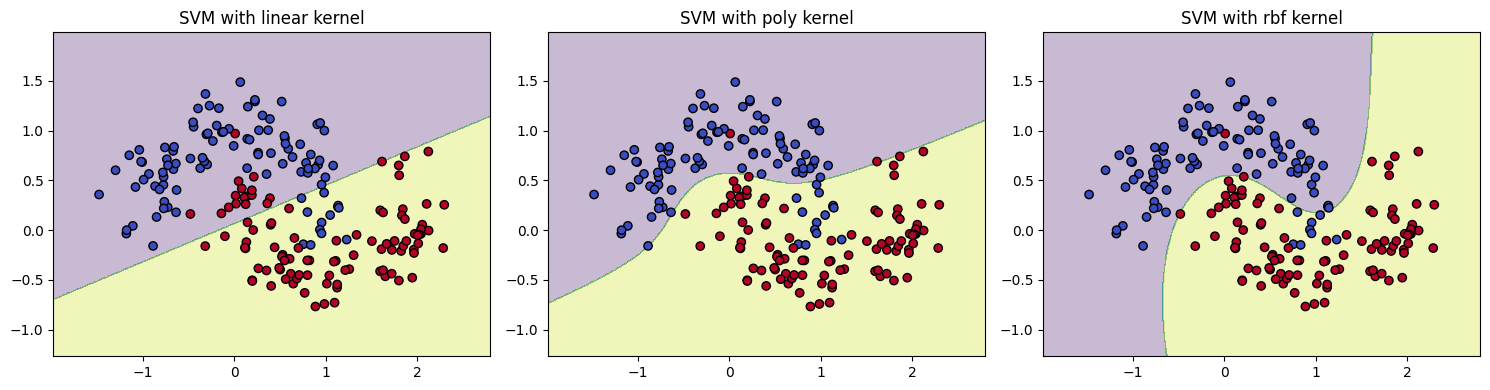

In [286]:
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(title)

# Plot all models
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, kernel in enumerate(kernels):
    plot_decision_boundary(models[kernel], X, y, axs[i], f"SVM with {kernel} kernel")

plt.tight_layout()
plt.show()


## Question

Based on the decision boundaries you observed for the three kernels (linear, polynomial, RBF), answer the following:

**Which kernel would you choose for a dataset where the classes form concentric circles, and why?**

Write your answer below with a brief explanation of how the kernel helps the SVM perform well in that situation.

The most suitable choice for a dataset with concentric circles is the RBF (Radial Basis Function or Gaussian) kernel.
The RBF kernel enables the SVM to construct non-linear, curved decision boundaries that adapt to the data's shape. In the case of concentric circles, linear separation is not possible, and even polynomial kernels may struggle. The RBF kernel, however, is well-equipped to handle such complex, non-linear structures by effectively transforming the feature space. This allows the SVM to distinguish between circular patterns with higher accuracy.


